# Сравнение функций правдоподобия для метода статистической деконволюции

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
from modules_reloader import reloader
from modules import randomized_ir, utils, plots

relmod = reloader(randomized_ir, utils, plots)

In [5]:
from random import random

L_true = 10
ir_x = np.linspace(0, L_true, int(L_true * 100))
ir_y = np.exp(-0.5 * ir_x)
rir = randomized_ir.RandomizedIr(ir_x, ir_y, factor=lambda: 0.75 + random() * 0.25)
stats = randomized_ir.RandomizedIrStats(rir, samplesize=10 ** 5)

# Прямое сравнение likelihood определённых разными методами

In [6]:
N = 10
n_vec_mean = 15
n_vec = utils.generate_poissonian_ns(n_vec_mean, N)
s_vec = rir.convolve_with_n_vec(n_vec)
n_vec_estimation = stats.estimate_n_vec(s_vec)

In [6]:
rng = np.random.default_rng()

# creating evaluation points grouped somwhere around maximum likelihood point
N_evaluation_points = 30
spread_from_estimation = 1  # from n_vec_estimation, in n units
evaluation_points = np.tile(n_vec_estimation, (N_evaluation_points, 1)) + rng.normal(scale=spread_from_estimation, size=(N_evaluation_points, N))

In [34]:
@utils.timer(args_formatter=lambda l, p: l.__name__ + f', {p.shape[0]} points')
def evaluate_loglike(loglike, points):
    results = []
    for p in tqdm(points):
        results.append(np.exp(loglike(p)))  # converting loglike back to regular PDF for comparison
    return np.array(results)

In [35]:
mc_loglike = stats.get_loglikelihood_monte_carlo(s_vec)
normdist_loglike = stats.get_loglikelihood_normdist(s_vec)

print(f"MC loglike = {mc_loglike(n_vec_estimation, progress=True)}")
print(f"Normdist loglike{normdist_loglike(n_vec_estimation)}")


There's 1995 points per bin -- seems enough;median is 3.0 among nonzero bins
MC loglike = -0.37043597906751385
Normdist loglike3.4394828423992765


In [8]:
# normdist_results = evaluate_loglike(stats.get_loglikelihood_normdist(s_vec), evaluation_points)
# np.savetxt('../precomputed/normdist_results.txt', normdist_results)

In [9]:
# mc_results = evaluate_loglike(stats.get_loglikelihood_monte_carlo(s_vec), evaluation_points)
# np.savetxt('../precomputed/mc_results.txt', mc_results)

In [10]:
normdist_results = np.loadtxt('../precomputed/normdist_results.txt')
mc_results = np.loadtxt('../precomputed/mc_results.txt')

In [11]:
average = 0.5 * (normdist_results + mc_results)
residual = normdist_results - mc_results

print(f'values around {np.mean(average)}')
print(f'residual = {np.mean(residual)} +/- {np.std(residual)}')
print(f'relative = {100 * np.mean(residual / average):.2f} +/- {100 * np.std(residual / average):.2f}%')

values around 0.0023155141399187414
residual = 0.00016763725397184748 +/- 0.0011824804472728198
relative = 2.33 +/- 66.13%


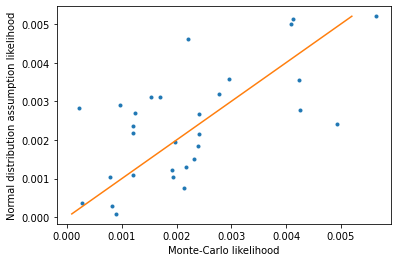

In [12]:
min_l = min(normdist_results.min(), mc_results.min())
max_l = min(normdist_results.max(), mc_results.max())
rng_l = np.linspace(min_l, max_l)

plt.plot(mc_results, normdist_results, '.')
plt.plot(rng_l, rng_l)

plt.xlabel('Monte-Carlo likelihood')
plt.ylabel('Normal distribution assumption likelihood')
# plt.yscale('log')
# plt.xscale('log')
plt.show()

Резюме: прямое сравнение распределений не даёт особого результата из-за флуктуаций многомерной гистограммы для оценки PDF

# Оценка применимости независимо-нормального приближения

In [6]:
def generate_S_sample(n_vec_mean):
    """end-to-end wrapper around whole procedure"""
    N = 50
    n_vec = utils.generate_poissonian_ns(n_vec_mean, N)
    s_vec = rir.convolve_with_n_vec(n_vec)
    n_vec_estimation = stats.estimate_n_vec(s_vec)
    S_sample = stats.sample_S_vec(n_vec_estimation, 50000, progress=True)
    return S_sample

In [7]:
n_vec_means = [1, 2, 4, 10]
S_samples = [generate_S_sample(nvm) for nvm in n_vec_means]

In [8]:
relmod()

## Частные распределения

(<Figure size 504x576 with 12 Axes>,
 array([[<AxesSubplot:title={'center':'«Лучший» бин'}, ylabel='$\\bar{n} = 1$'>,
         <AxesSubplot:title={'center':'«Медианный» бин'}>,
         <AxesSubplot:title={'center':'«Худший» бин'}>],
        [<AxesSubplot:ylabel='$\\bar{n} = 2$'>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='$\\bar{n} = 4$'>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:xlabel='$S_j$', ylabel='$\\bar{n} = 10$'>,
         <AxesSubplot:xlabel='$S_j$'>, <AxesSubplot:xlabel='$S_j$'>]],
       dtype=object))

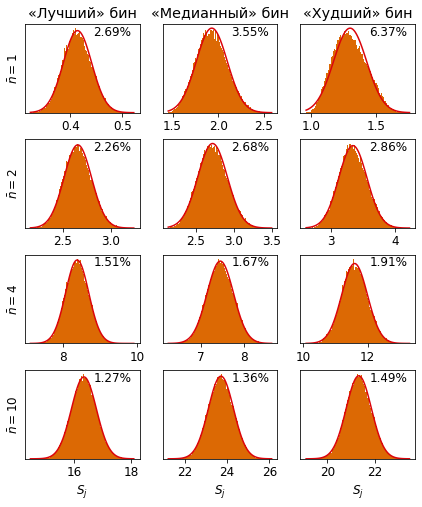

In [11]:
plots.plot_S_j_marginal_normality_assessment(S_samples, n_vec_means, stats.L, filename='S-j-normality-assessment.pdf')

## Попарные корреляции

In [28]:
relmod()

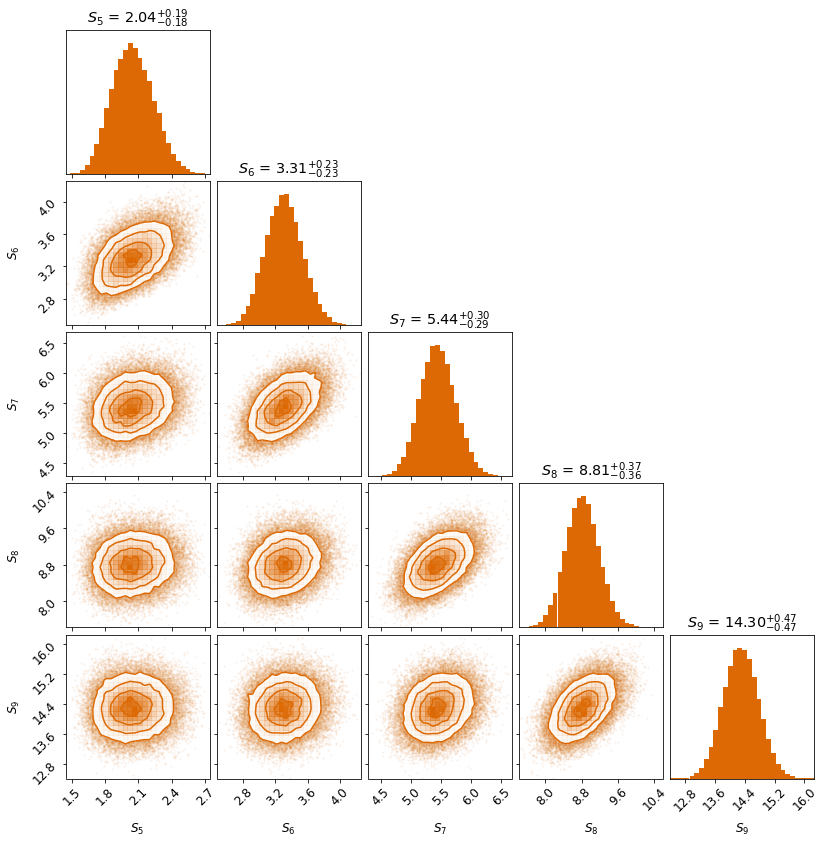

In [29]:
f = plots.plot_S_j_pairwise_normality_assessment(S_samples[-1], stats.L, filename='S-j-pairwise-normality-assessment.pdf')

In [9]:
from scipy.stats import pearsonr
from itertools import tee

In [12]:
def pairwise_correlations(S_sample, distance: int = 1):
    prev, curr = tee(S_sample)
    for _ in range(distance):
        next(curr, None)
    rs = []
    for prev_sample, curr_sample in zip(prev, curr):
        r, pval = pearsonr(prev_sample, curr_sample)
        rs.append(r)
    return np.array(rs)

In [20]:
rs = pairwise_correlations(S_sample, distance=1)

print(rs)

[0.20620183 0.22082432 0.36923183 0.397113   0.37015443 0.41289469
 0.30430594 0.42409628 0.35662721 0.9840729  0.91281057 0.72376211
        nan]
